# NAME     : Bhavik Ransubhe
# CLASS    : B.E (B) COMPUTER
# ROLL No. : 41261

## MLDS 
### Assignment No. 4 : Text classification for Sentimental analysis using KNN- use twitter data

In [1]:
import pandas as pd
import re
import numpy as np
import scipy
import itertools
import matplotlib
import matplotlib.pyplot as plt
import warnings
from scipy.spatial.distance import cdist
from collections import Counter
from random import choice

In [2]:
# Storing the training and test datasets into their respective dataframes
trained = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
print(trained.head())
print(test.head())

  Sentiment                                              Tweet
0   neutral  @united 877 from amsterdam to ewr, 02.27.2015,...
1  negative       @united IT-problems with the link? #3thparty
2  positive  @united -today the staff @ MSP took customer s...
3  negative  @AmericanAir but have been yet to receive assi...
4  negative  @SouthwestAir  you won't let me change my rese...
  Sentiment                                              Tweet
0   neutral  @VirginAmerica to jump into the Dallas-Austin ...
1  positive  @AmericanAir Chicago seen from seat 6A, AA 162...
2  negative    @united you need a bag bouncer. Get it together
3  negative  @JetBlue Hey Jetblue, you stranded an entire p...
4  negative  @USAirways Big fail on not having curbside bag...


Data Preprocessing we have to remove the stop words, punctuation marks and other unwanted characters from the tweets and convert them to lower case.

In [3]:
trained['Tweet'] = trained['Tweet'].str.lower() # Ensuring all words in the Tweet column of training data are lowercased
test['Tweet'] = test['Tweet'].str.lower() # Ensuring all words in the Tweet column of test data are lowercased

In [4]:
print(trained.head())
print(test.head())

  Sentiment                                              Tweet
0   neutral  @united 877 from amsterdam to ewr, 02.27.2015,...
1  negative       @united it-problems with the link? #3thparty
2  positive  @united -today the staff @ msp took customer s...
3  negative  @americanair but have been yet to receive assi...
4  negative  @southwestair  you won't let me change my rese...
  Sentiment                                              Tweet
0   neutral  @virginamerica to jump into the dallas-austin ...
1  positive  @americanair chicago seen from seat 6a, aa 162...
2  negative    @united you need a bag bouncer. get it together
3  negative  @jetblue hey jetblue, you stranded an entire p...
4  negative  @usairways big fail on not having curbside bag...


In [5]:
# Parsing the stop_words.txt file and storing all the words in a list.
stopwords = []
with open('stopwords.txt','r') as file:    
    for line in file:         
        for word in line.split():            
            stopwords.append(word)

In [6]:
# Removing all stopwords from all the tweets in training data.
trained["Tweet"] = trained["Tweet"].apply(lambda func: ' '.join(sw 
                                          for sw in func.split() 
                                          if sw not in stopwords))

# Removing all stopwords from all the tweets in test data.
test["Tweet"] = test["Tweet"].apply(lambda func: ' '.join(sw 
                                          for sw in func.split() 
                                          if sw not in stopwords))
print(trained.head())

  Sentiment                                              Tweet
0   neutral    @united 877 amsterdam ewr, 02.27.2015, 737-300.
1  negative                @united it-problems link? #3thparty
2  positive  @united -today staff @ msp took customer servi...
3  negative  @americanair receive assistance agents securin...
4  negative  @southwestair won't let change reservation onl...


In [7]:
#List of all special characters that are to be removed.
special_chars = ["!",'"',"%","&","amp","'","(",")", "*","+",",","-",".",
                 "/",":",";","<","=",">","?","[","\\","]","^","_",
                 "`","{","|","}","~","–","@","#","$"]

In [8]:

#Training Data
trained['Tweet'] = trained['Tweet'].str.replace(r'http?://[^\s<>"]+|www\.[^\s<>"]+', '') # Removing hyperlinks from all the tweets. They are not needed for classification.
trained['Tweet'] = trained['Tweet'].str.replace('@[A-Za-z0-9]+', '') # Removing usernames from all the tweets.
trained['Tweet'] = trained['Tweet'].str.replace(r'\B#\w*[a-zA-Z]+\w*', '') # Removing hashtags, including the text, from all the tweets. Hashtags are useless since their words cannot be splitted with spaces.
trained['Tweet'] = trained['Tweet'].str.replace('\d+', '') # Removing numbers from all the tweets. They will not assist in any way to improve the classification process.

for c in special_chars:
    trained['Tweet'] = trained['Tweet'].str.replace(c,'') # Removing all special characters from all the tweets

#Test Data
test['Tweet'] = test['Tweet'].str.replace(r'http?://[^\s<>"]+|www\.[^\s<>"]+', '') # Removing hyperlinks from all the tweets
test['Tweet'] = test['Tweet'].str.replace('@[A-Za-z0-9]+', '') # Removing usernames from all the tweets.
test['Tweet'] = test['Tweet'].str.replace(r'\B#\w*[a-zA-Z]+\w*', '') # Removing hashtags, including the text, from all the tweets
test['Tweet'] = test['Tweet'].str.replace('\d+', '') # Removing numbers from all the tweets

for c in special_chars:
    test['Tweet'] = test['Tweet'].str.replace(c,'') # Removing all special characters from all the tweets

In [9]:
print(trained.head())

  Sentiment                                              Tweet
0   neutral                                    amsterdam ewr  
1  negative                                   itproblems link 
2  positive   today staff  msp took customer service new le...
3  negative   receive assistance agents securing new connec...
4  negative   wont let change reservation online now im jus...


In [10]:
print(test.head())

  Sentiment                                              Tweet
0   neutral                    jump dallasaustin market  news 
1  positive        chicago seen seat a aa  far great ride pdx 
2  negative                                   need bag bouncer
3  negative   hey jetblue stranded entire plane supposed jf...
4  negative   big fail curbside baggage pittsburgh charge  ...


In [11]:
#Training Data
train_unique = (list(set(trained['Tweet'].str.findall("\w+").sum()))) # Finding all the unique words in training data's Tweet column
train_unique_words = len(train_unique)

#Test Data
test_unique = (list(set(test['Tweet'].str.findall("\w+").sum()))) # Finding all the unique words in test data's Tweet column
test_unique_words = len(test_unique)

print("Unique words in Training Data: {}".format(train_unique_words))
print("Unique words in Test Data: {}".format(test_unique_words))

Unique words in Training Data: 9955
Unique words in Test Data: 4749


**Feature Extraction**

In [12]:
#Training Data
train_matrix = [] # Forming a 2D matrix to store all training feature vectors

#Test Data
test_matrix = [] # Forming a 2D matrix to store all test feature vectors

In [13]:
#Training Data: Extracting features and storing them into the training feature matrix
for sentence in trained['Tweet']:
    train_featurevec = []
    word = sentence.split()
    for w in train_unique:
        train_featurevec.append(word.count(w))
    train_matrix.append(train_featurevec)

#Test Data: Extracting features and storing them into the test feature matrix
for sentence in test['Tweet']:
    test_featurevec = []
    word = sentence.split()
    for w in train_unique:
        test_featurevec.append(word.count(w))
    test_matrix.append(test_featurevec)

In [14]:
print("Shape of Training Matrix: ({0} , {1})".format(len(train_matrix),len(train_matrix[0])))
print(len(train_matrix))
print("Shape of Test Matrix: ({0} , {1})".format(len(test_matrix),len(test_matrix[0])))

Shape of Training Matrix: (11680 , 9955)
11680
Shape of Test Matrix: (2921 , 9955)


**KNN**

In [15]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix

#Initializing lists to be used in plotting later.
acc_list = []
rec_list = []
prec_list = []
f1_list = []

In [16]:
def classifying(trainfeatures,testfeatures):

  X_train = trainfeatures #train_matrix - 2D feature vector
  X_test = testfeatures #test_matrix - 2D feature vector
  y_train = trained.iloc[:,0].values #trained['Sentiment]
  y_test = test.iloc[:,0].values #test['Sentiment]

  for k in [1,3,5,7,10]:

    classifier = KNeighborsClassifier(n_neighbors=k,algorithm='brute') #Using brute-force algorithm for quicker computation.
    classifier.fit(X_train, y_train) #Fitting the built-in sklearn classifier on our training data
    predicted_label = classifier.predict(X_test) #Making the classifier to predict on the previously unseen test data.

    accuracy_score = (metrics.accuracy_score(y_test,predicted_label))
    accuracy_score = (round(accuracy_score,2))*100
    acc_list.append(accuracy_score)

    confusion_mat = confusion_matrix(y_test, predicted_label)
    class_report = classification_report(y_test, predicted_label)

    macro_precision = (metrics.precision_score(y_test, predicted_label, average='macro'))
    macro_precision = (round(macro_precision,2))*100
    prec_list.append(macro_precision)

    macro_recall = (metrics.recall_score(y_test, predicted_label, average='macro'))
    macro_recall = (round(macro_recall,2))*100
    rec_list.append(macro_recall)
    
    macro_f1 = (metrics.f1_score(y_test, predicted_label, average='macro'))
    macro_f1 = (round(macro_f1,2))*100
    f1_list.append(macro_f1)

    print("\n\nConfusion Matrix for k = {} is:\n".format(k))
    print(confusion_mat)
    print("\nClassification Report for k = {} is:\n".format(k))
    print(class_report)
    print("Accuracy Score for k = {0} is: {1}%".format(k,accuracy_score))
    print("Macroaveraged Recall for k = {0} is: {1}%".format(k,macro_recall))
    print("Macroaveraged Precision for k = {0} is: {1}%".format(k,macro_precision))
    print("Macroaveraged F1-score for k = {0} is: {1}%".format(k,macro_f1))

In [17]:
classifying(train_matrix,test_matrix)



Confusion Matrix for k = 1 is:

[[774 877 183]
 [ 77 455  83]
 [ 51 192 229]]

Classification Report for k = 1 is:

              precision    recall  f1-score   support

    negative       0.86      0.42      0.57      1834
     neutral       0.30      0.74      0.43       615
    positive       0.46      0.49      0.47       472

    accuracy                           0.50      2921
   macro avg       0.54      0.55      0.49      2921
weighted avg       0.68      0.50      0.52      2921

Accuracy Score for k = 1 is: 50.0%
Macroaveraged Recall for k = 1 is: 55.00000000000001%
Macroaveraged Precision for k = 1 is: 54.0%
Macroaveraged F1-score for k = 1 is: 49.0%


Confusion Matrix for k = 3 is:

[[ 690 1045   99]
 [  56  502   57]
 [  47  203  222]]

Classification Report for k = 3 is:

              precision    recall  f1-score   support

    negative       0.87      0.38      0.53      1834
     neutral       0.29      0.82      0.42       615
    positive       0.59      0.47  

<function matplotlib.pyplot.show(*args, **kw)>

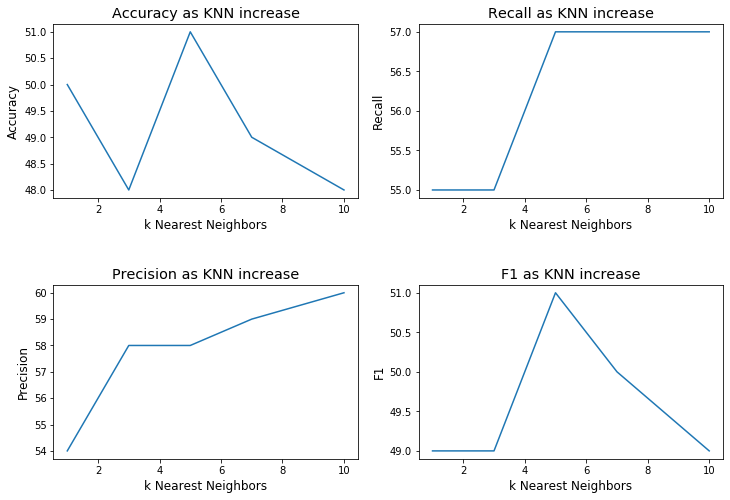

In [18]:
k_ls = [1,3,5,7,10] 

fig = plt.figure(figsize=(12,8))

plt.subplot(2,2,1)
plt.plot(k_ls,acc_list)
plt.title("Accuracy as KNN increase",fontsize='x-large')
plt.xlabel("k Nearest Neighbors",fontsize='large')
plt.ylabel("Accuracy",fontsize='large')

plt.subplot(2,2,2)
plt.plot(k_ls,rec_list)
plt.title("Recall as KNN increase",fontsize='x-large')
plt.xlabel("k Nearest Neighbors",fontsize='large')
plt.ylabel("Recall",fontsize='large')

plt.subplot(2,2,3)
plt.plot(k_ls,prec_list)
plt.title("Precision as KNN increase",fontsize='x-large')
plt.xlabel("k Nearest Neighbors",fontsize='large')
plt.ylabel("Precision",fontsize='large')

plt.subplot(2,2,4)
plt.plot(k_ls,f1_list)
plt.title("F1 as KNN increase",fontsize='x-large')
plt.xlabel("k Nearest Neighbors",fontsize='large')
plt.ylabel("F1",fontsize='large')

fig.subplots_adjust(hspace=.5)

plt.show